In [1]:
# dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, and_

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime
from datetime import date
import seaborn as sns

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
# reflect database into ORM classes & check classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# create references to the tables
measurement = Base.classes.measurement
station = Base.classes.station

In [5]:
session = Session(engine)

### Precipitation Analysis
Design a query to retrieve the last 12 months of precipitation data.

In [6]:
# retrieve latest date in the data
max_date = (session
            .query(measurement, measurement.date)
            .order_by(measurement.date.desc())
            .first()[1])
print(f'The latest date on record is {max_date}')

The latest date on record is 2017-08-23


In [7]:
# find the date 12 months prior to the latest date
start_date = max_date - datetime.timedelta(365)
print(f'The start date is {start_date}')

The start date is 2016-08-23


In [8]:
# Extract data & load into a pandas df
prcp_ls = (session
            .query(measurement.date,measurement.prcp)
            .filter(measurement.date > start_date)
            .order_by(measurement.date)
            .all())
prcp_df = pd.DataFrame(prcp_ls, columns=['Date','Precipitation'])
prcp_df = prcp_df.set_index('Date')
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


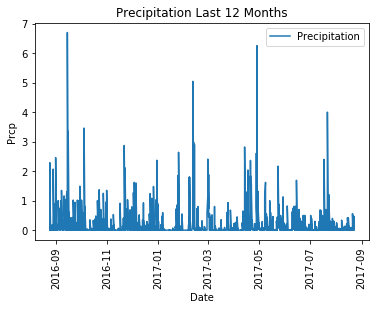

In [9]:
# plot the prcp data into chart
prcp_df.plot()
plt.title("Precipitation Last 12 Months")
plt.xlabel("Date")
plt.xticks(rotation='vertical')
plt.ylabel("Prcp")
sns.set
plt.show()

In [10]:
# prcp statistic summary
prcp_df.describe()

,Precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


### Station Analysis
1. Design a query to find the most active stations
2. Design a query to retrieve the last 12 months of temperature observation data

In [11]:
# find number of stations
num_stations = (session
               .query(station.station)
               .count())
print(f'The number of stations is {num_stations}')

The number of stations is 9


In [12]:
# find the most active station 
active_station = (session
                 .query(measurement.station, func.count(measurement.date))
                 .group_by(measurement.station)
                 .order_by(desc(func.count(measurement.date)))
                 .all())
most_active_station = active_station[0][0]
num_obser = active_station[0][1]
print(f'The most active station is {most_active_station}')
print(f'The number of observation for {most_active_station} is {num_obser}')

The most active station is USC00519281
The number of observation for USC00519281 is 2772


In [13]:
# list the stations and observation counts in descending order
active_st_df = pd.DataFrame(active_station, columns=['Station ID','Number of Observation'])
active_st_df.head()

,Station ID,Number of Observation
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [15]:
# extract temp observation data & load into a pandas df
temp_obser = (session
             .query(measurement.date, measurement.tobs)
             .filter(and_(measurement.date > start_date
                          ,measurement.station == most_active_station))
             .all())
temp_obs_df = pd.DataFrame(temp_obser, columns=['Date','Temp'])
temp_obs_df = temp_obs_df.set_index('Date')
temp_obs_df.head()

,Temp
Date,
2016-08-24,77
2016-08-25,80
2016-08-26,80
2016-08-27,75
2016-08-28,73


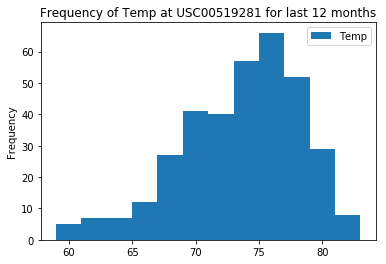

In [16]:
# plot the temp distribution into a histogram
temp_obs_df.plot.hist(title = f'Frequency of Temp at {most_active_station} for last 12 months'
                      ,bins = 12)
sns.set
plt.show()

### Temperature Analysis
1. Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.
2. Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
3. Plot the min, avg, and max temperature from your previous query as a bar chart.

In [32]:
def calc_temps(start_date,end_date):
    start_datetime = datetime.datetime.strptime(start_date,'%Y-%m-%d')
    end_datetime = datetime.datetime.strptime(end_date,'%Y-%m-%d')
    # get dates for prior year
    py_start_date = start_datetime - datetime.timedelta(365)
    py_end_date = end_datetime - datetime.timedelta(365)
    # query all temperature data between prior year dates
    temp_data = (session
                .query(measurement.date, measurement.tobs)
                .filter(and_(measurement.date >= py_start_date
                            ,measurement.date <= py_end_date))
                .all())
    # load extracted data into dataframe
    temp_df = pd.DataFrame(temp_data, columns=['date','tobs'])
    # find avg, max, and min
    average_temp = temp_df['tobs'].mean()
    max_temp = temp_df['tobs'].max()
    min_temp = temp_df['tobs'].min()
    return average_temp, max_temp, min_temp

In [33]:
trip_start_date = input('When do you want to start your trip (YYYY-MM-DD)?')

When do you want to start your trip (YYYY-MM-DD)?2018-02-14


In [34]:
trip_end_date = input('When do you want to start your trip (YYYY-MM-DD)?')

When do you want to start your trip (YYYY-MM-DD)?2018-04-01


In [48]:
selection = calc_temps(trip_start_date,trip_end_date)
average_temp = selection[0]
max_temp = selection[1]
min_temp = selection[2]
print(f'The average temperature is {average_temp}')
print(f'The maximum temperature is {max_temp}')
print(f'The minimum temperature is {min_temp}')
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = max_temp - min_temp
x_axis=1

The average temperature is 71.8540925266904
The maximum temperature is 82
The minimum temperature is 61


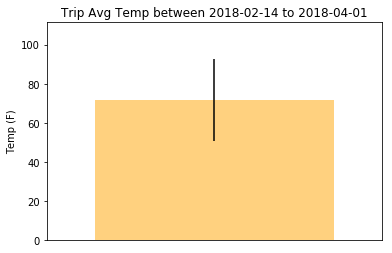

In [49]:
fig, ax = plt.subplots()
plot_bar = ax.bar(x_axis,average_temp,yerr=yerr,color='orange',align='center',alpha=0.5)
ax.set(xticks=range(x_axis)
       ,title=f"Trip Temp between {trip_start_date} to {trip_end_date}"
       ,ylabel="Temp (F)")
ax.margins(.2,.2)
sns.set
plt.show()